In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
import pylab

In [2]:
df=pd.read_csv('/content/train.csv')
df.drop(['id', 'Offer %'],axis='columns',inplace=True)

# I temporarily did not drop title column because it helped me understand null values
# Dropped Offer % as it wont be useful to train model and is connected to output price1

df.head()

,title,Rating,maincateg,platform,price1,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,38.0,7.0,17.0,9.0,6.0,3,3,0
1,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,531.0,69.0,264.0,92.0,73.0,29,73,1
2,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,17.0,4.0,11.0,3.0,2.0,1,0,1
3,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,77.0,3.0,35.0,21.0,7.0,7,7,1


In [3]:
#copy of train.csv just to plot data later
data=pd.read_csv('/content/train.csv')
data.drop('id',axis='columns', inplace=True)
data.shape

(15730, 15)

In [4]:
df.isnull().sum()

title           0
Rating          0
maincateg     526
platform        0
price1          0
actprice1       0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

In [5]:
#Converting offer % columns to float data type
data['Offer %']=data['Offer %'].str.replace('%','').astype('float')

#Initial look at data

In [6]:
df.isnull().sum(axis='columns').sum()

3140

~20% rows has null values, I will first do some basic data plots and then handle null values

<Axes: >

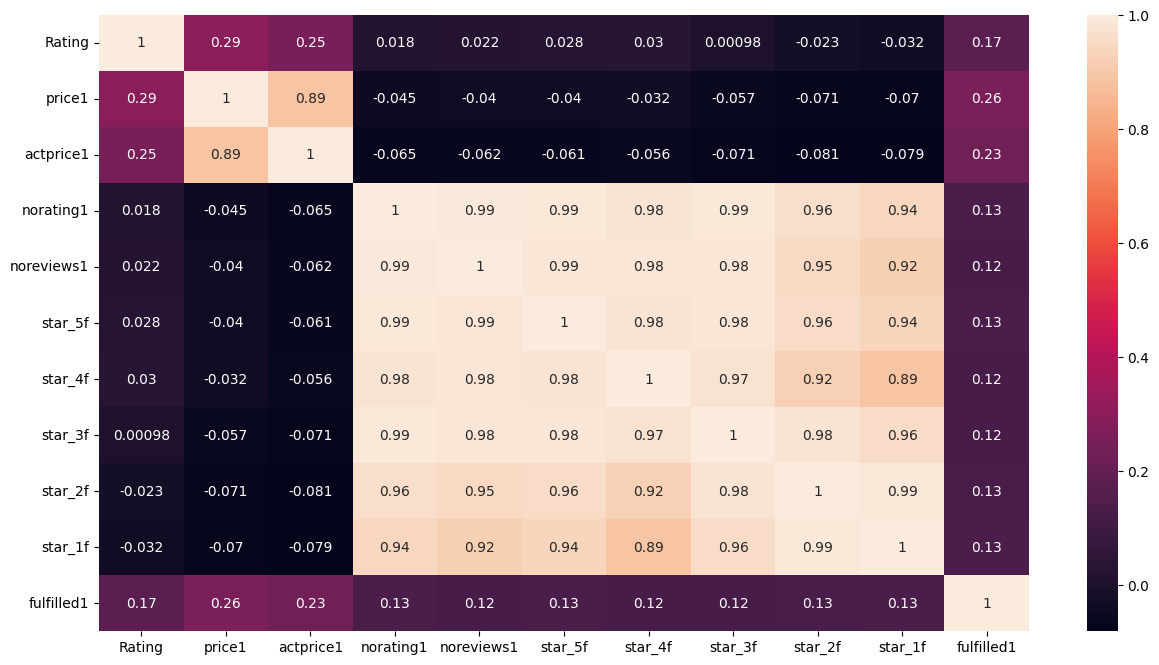

In [7]:
plt.figure(figsize=(15,8))
sns.heatmap(df.drop(['maincateg', 'title', 'platform'],axis='columns').corr(),annot=True)

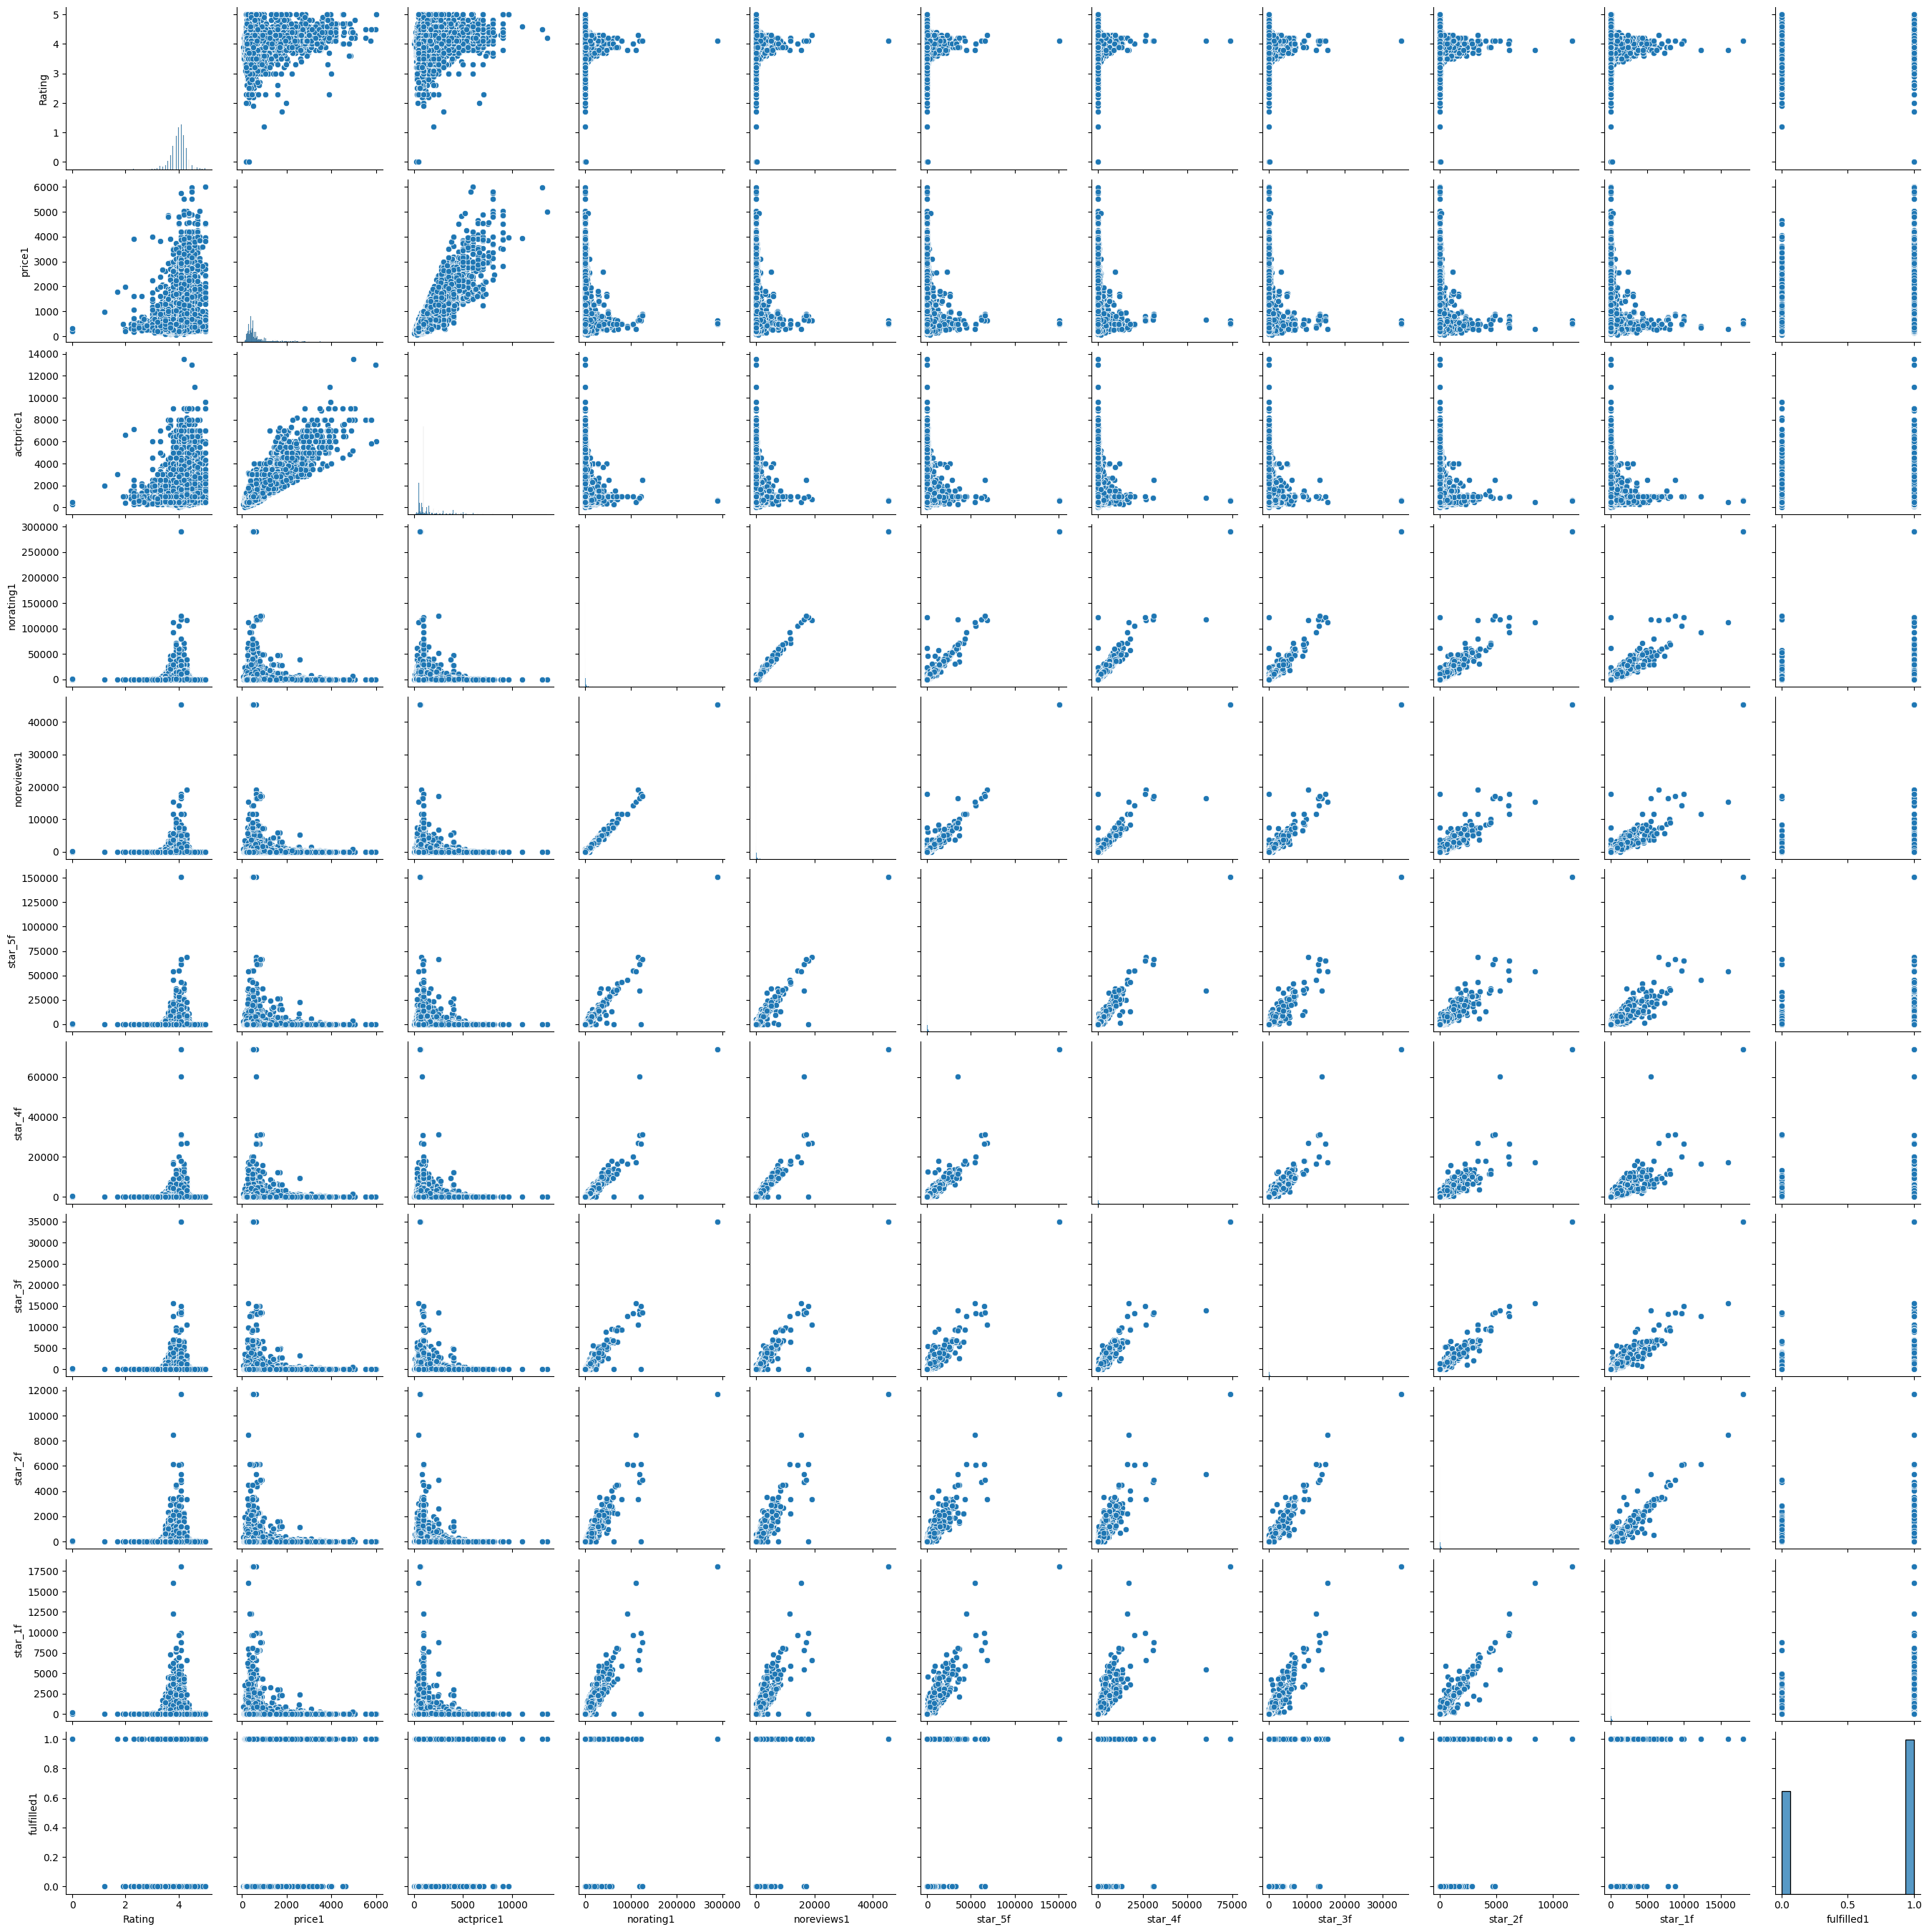

In [12]:
sns.pairplot(df)

The main conclusion I was able to make from this was that XGBRegressor is the best suited model to impute star_f columns and linear regression is best suited model for imputing noreviews1 from norating1

Also distribution of data from all star_f columns is identical nature, this can also be inferred from the correlation matrix which shows that all star_f columns, norating1 and noreview1 is highly correlated data

#Handling Nulls

In [8]:
df.isnull().sum()

title           0
Rating          0
maincateg     526
platform        0
price1          0
actprice1       0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

Maincateg null values

In [9]:
df['maincateg'].unique()

array(['Women', 'Men', nan], dtype=object)

In [10]:
df.loc[df['title'].str.upper().str.contains('WOMEN') & df['maincateg'].isnull(), ['maincateg']]='Women'
df.loc[df['title'].str.upper().str.contains('MEN')& df['maincateg'].isnull(), ['maincateg']]='Men'
df['maincateg'].isnull().sum()

57

In [11]:
df[df['maincateg'].isnull()].tail(5)

,title,Rating,maincateg,platform,price1,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
13690,Slippers,3.9,NaN,Flipkart,404,499,177.0,NaN,98.0,NaN,15.0,9,26,0
14218,Slippers,4.0,NaN,Flipkart,171,499,NaN,17.0,71.0,NaN,22.0,11,11,0
15177,Slides,3.9,NaN,Flipkart,245,299,NaN,210.0,NaN,NaN,277.0,139,236,1
15419,Slippers,3.8,NaN,Flipkart,386,998,NaN,NaN,NaN,NaN,13.0,4,10,1
15536,Slides,4.5,NaN,Flipkart,499,799,NaN,1.0,23.0,NaN,1.0,1,2,0


If maincateg is not given we can still figure out Men/Women from title.
The remaining of the null values in maincateg are unisexual products like slippers

In [13]:
df.loc[df['maincateg'].isnull(),['maincateg']]='Unisex'
print(df['maincateg'].unique())
df['maincateg'].isnull().sum()

['Women' 'Men' 'Unisex']


0

In [14]:
df.isnull().sum()

title           0
Rating          0
maincateg       0
platform        0
price1          0
actprice1       0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

##star_f and norating1 Null Values

I decided to impute the null values of star_f columns using XGBRegressor Model

For norating1 column (number of ratings) i filled null values using sum of all star_f columns

In [15]:
lrm5 = XGBRegressor()
x_lrm5=np.array(df.loc[df['star_5f'].notna(),['Rating','star_2f', 'star_1f']])
y_lrm5=np.array(df.loc[df['star_5f'].notna()]['star_5f'])
lrm5.fit(x_lrm5, y_lrm5)
df.loc[df['star_5f'].isnull(),['star_5f']]=lrm5.predict(np.array(df.loc[df['star_5f'].isnull(),['Rating','star_2f','star_1f']]))

In [16]:
lrm4=XGBRegressor()
x_lrm4=np.array(df.loc[df['star_4f'].notna(),['Rating','star_2f','star_1f']])
y_lrm4=np.array(df.loc[df['star_4f'].notna()]['star_4f'])
lrm4.fit(x_lrm4,y_lrm4)
df.loc[df['star_4f'].isnull(), ['star_4f']]=lrm4.predict(np.array(df.loc[df['star_4f'].isnull(),['Rating','star_2f','star_1f']]))

In [17]:
lrm3=XGBRegressor()
x_lrm3=np.array(df.loc[df['star_3f'].notna(),['Rating','star_2f','star_1f']])
y_lrm3=np.array(df.loc[df['star_3f'].notna()]['star_3f'])
lrm3.fit(x_lrm3,y_lrm3)
df.loc[df['star_3f'].isnull(),['star_3f']]=lrm3.predict(np.array(df.loc[df['star_3f'].isnull(),['Rating','star_2f','star_1f']]))

In [18]:
df.loc[df['norating1'].isnull(),'norating1']=df.loc[df['norating1'].isnull(),'star_5f']+df.loc[df['norating1'].isnull(),'star_4f']+df.loc[df['norating1'].isnull(),'star_3f']+df.loc[df['norating1'].isnull(),'star_2f']+df.loc[df['norating1'].isnull(),'star_1f']

In [19]:
df.isnull().sum()

title           0
Rating          0
maincateg       0
platform        0
price1          0
actprice1       0
norating1       0
noreviews1    578
star_5f         0
star_4f         0
star_3f         0
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

##noreviews1 Null Values

<Axes: xlabel='norating1', ylabel='noreviews1'>

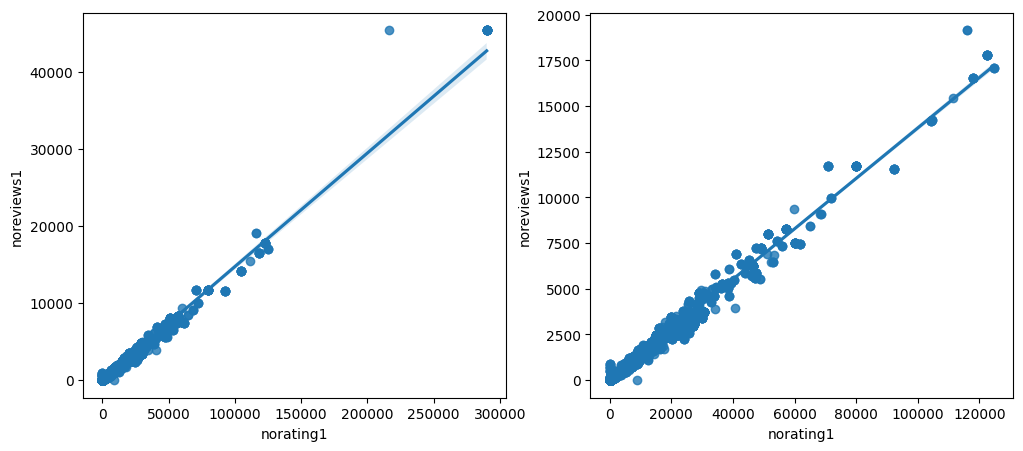

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.regplot(x=df['norating1'],y=df['noreviews1'])
plt.subplot(1,2,2)
sns.regplot(x=df[df['noreviews1']<20000]['norating1'],y=df[df['noreviews1']<20000]['noreviews1'])

Judging the plot between norating1 and noreviews1, i decided to use linear regression model to impute noreviews1 null values

In [21]:
lrg=LinearRegression()
x_lrg=df[df['noreviews1']<20000]['norating1'].values.reshape(-1,1)
y_lrg=df[df['noreviews1']<20000]['noreviews1'].values
lrg.fit(x_lrg,y_lrg)
df.loc[df['noreviews1'].isnull(),'noreviews1']=lrg.predict(df[df['noreviews1'].isnull()]['norating1'].values.reshape(-1,1))

In [22]:
df.isnull().sum()

title         0
Rating        0
maincateg     0
platform      0
price1        0
actprice1     0
norating1     0
noreviews1    0
star_5f       0
star_4f       0
star_3f       0
star_2f       0
star_1f       0
fulfilled1    0
dtype: int64

#Plotting data

In [23]:
data.columns

Index(['title', 'Rating', 'maincateg', 'platform', 'price1', 'actprice1',
       'Offer %', 'norating1', 'noreviews1', 'star_5f', 'star_4f', 'star_3f',
       'star_2f', 'star_1f', 'fulfilled1'],
      dtype='object')

<ipython-input-24-4f7900fd1409>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[i])
<ipython-input-24-4f7900fd1409>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[i])
<ipython-input-24-4f7900fd1409>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seab

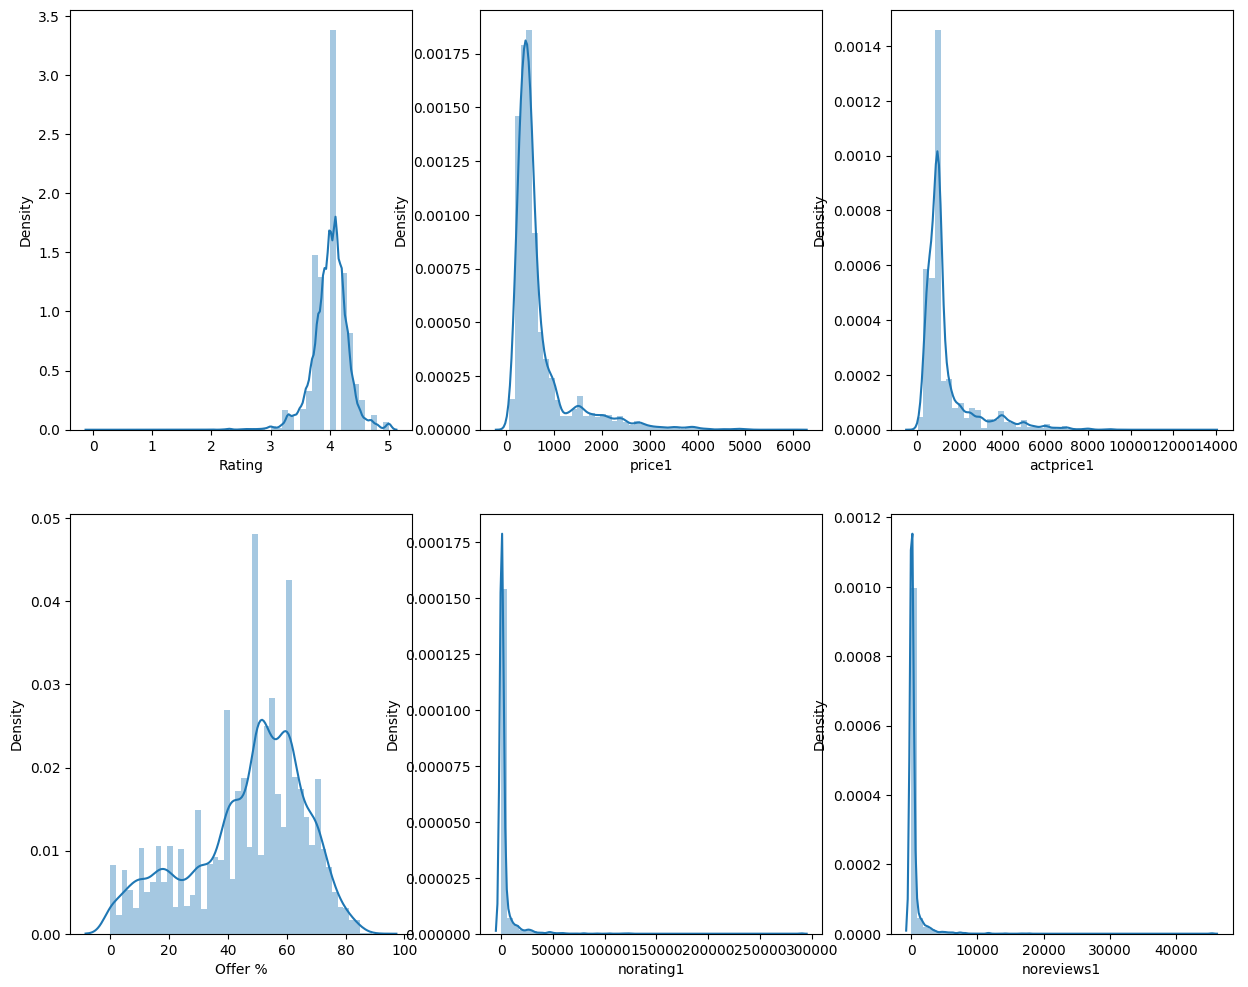

In [24]:
plt.figure(figsize=(15,12))
plt_cols=['Rating','price1','actprice1','Offer %','norating1','noreviews1']

# I didnt plot the star_f columns because they are highly correlated to norating1 and noreviews1
# columns & have similar distributions to them

k=1
for i in plt_cols:
  plt.subplot(2,3,k)
  sns.distplot(data[i])
  k=k+1

1. Distribution of Rating column is very close to a normal distibution
2. The distribution of norating1 and noreviews1 column is heavily skewed, this is because of a continuous distribution of outliers from 5000-30000 while most of the data is in less than 1000 range
3. actprice1 and price1 are not 'perfect' normal distributions and are slightly skewed
4. Offer % is a column that will not be used as it is not provided in testing data, its just easier to understand



<Axes: title={'center': 'norating1 > 10000'}, xlabel='norating1', ylabel='Count'>

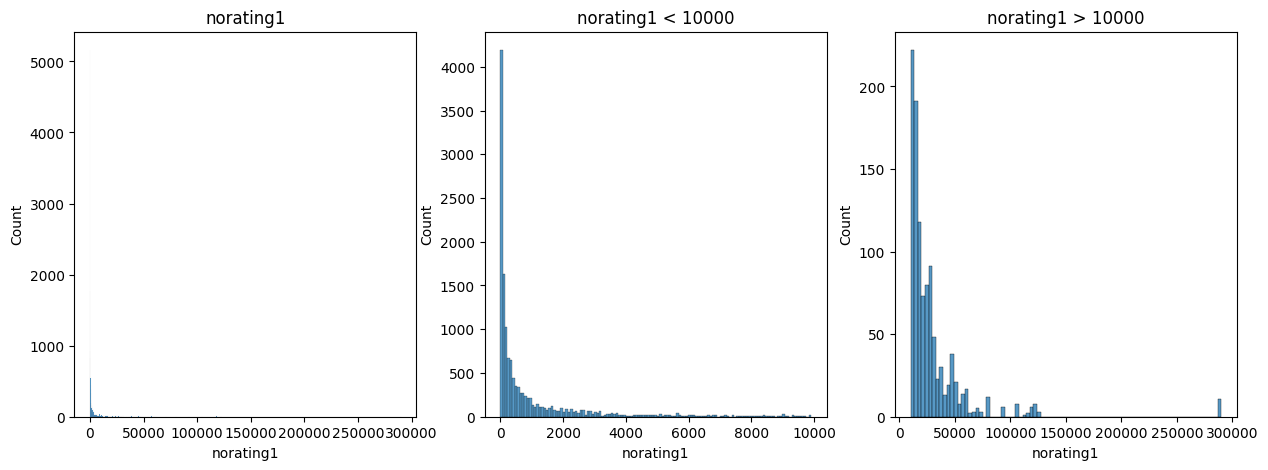

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('norating1')
sns.histplot(data['norating1'])
plt.subplot(1,3,2)
plt.title('norating1 < 10000')
sns.histplot(data[data['norating1']<10000]['norating1'])
plt.subplot(1,3,3)
plt.title('norating1 > 10000')
sns.histplot(data[data['norating1']>10000]['norating1'])

I could not think of any good changes to implement on the norating1 and noreviews1 column because this sort of distribution is expected(i could be wrong) and i cannot drop data as outliers, as there will be products that sell more and have more number of reviews & rating but that does not tell us much about quality of product or expected offer % on that product, it only tells that this product is well marketed and sold more units

<ipython-input-26-f22fac12995b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['actprice1'])
<ipython-input-26-f22fac12995b>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['price1'])


<Axes: title={'center': 'discounted price'}, xlabel='price1', ylabel='Density'>

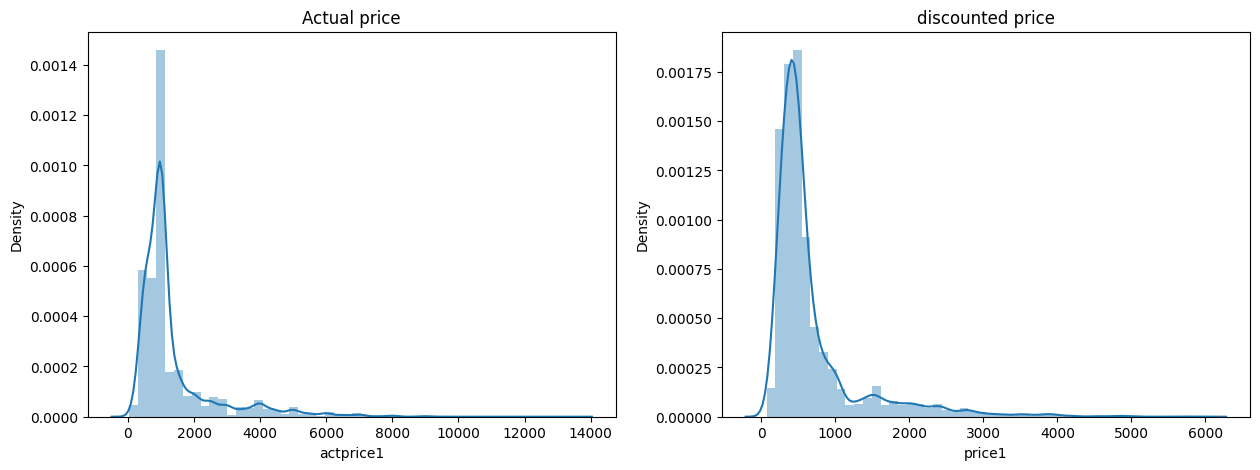

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Actual price')
sns.distplot(data['actprice1'])
plt.subplot(1,2,2)
plt.title('discounted price')
sns.distplot(data['price1'])

Looking at the distribution of these 2 columns, I decided to try making actprice1 column more normally distributed as that would help the model and would also match the distribution of output column price1 better

To start I made some qq plots and tried some feature transformations

((array([-3.9211465 , -3.70198712, -3.58193389, ...,  3.58193389,
          3.70198712,  3.9211465 ]),
  array([1.92575915, 2.09709306, 2.16217178, ..., 2.41221591, 2.41594487,
         2.41675293])),
 (0.03553053506005497, 2.317756679065056, 0.9742690025845356))

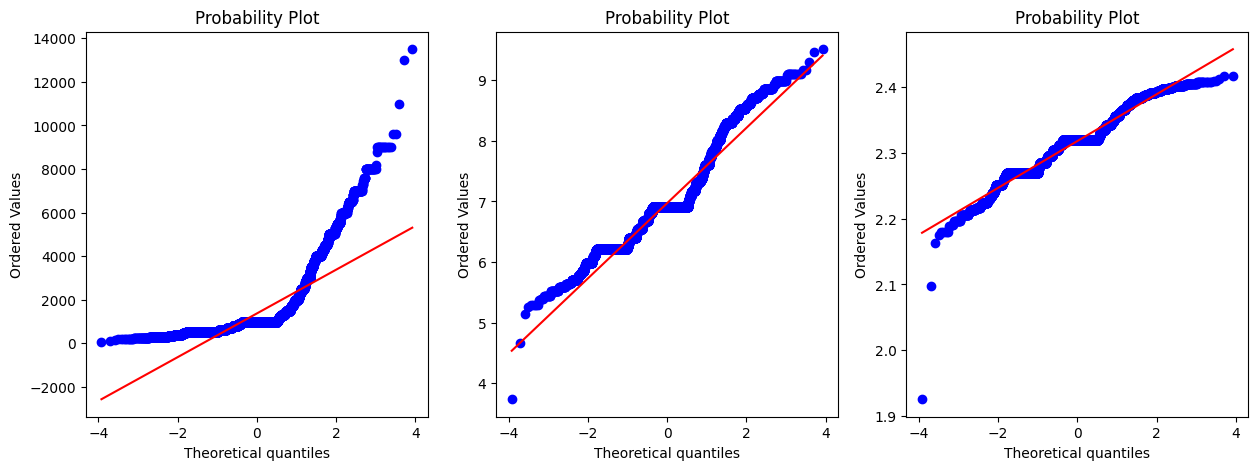

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
stats.probplot(data['actprice1'],plot=pylab)
plt.subplot(1,3,2)
stats.probplot(np.log(data['actprice1']),plot=pylab)
var,_=stats.boxcox(data['actprice1'])
plt.subplot(1,3,3)
stats.probplot(var,plot=pylab)

1. Based on these transformations I added logprice column by taking log of actprice1 column
2. I didnt drop actprice1 beacuse price1 column is generated by transforming actprice1

In [28]:
df['logprice']=np.log(df['actprice1'])

#Making features from title

So my initial idea was to look for words that are related to offers/discounts

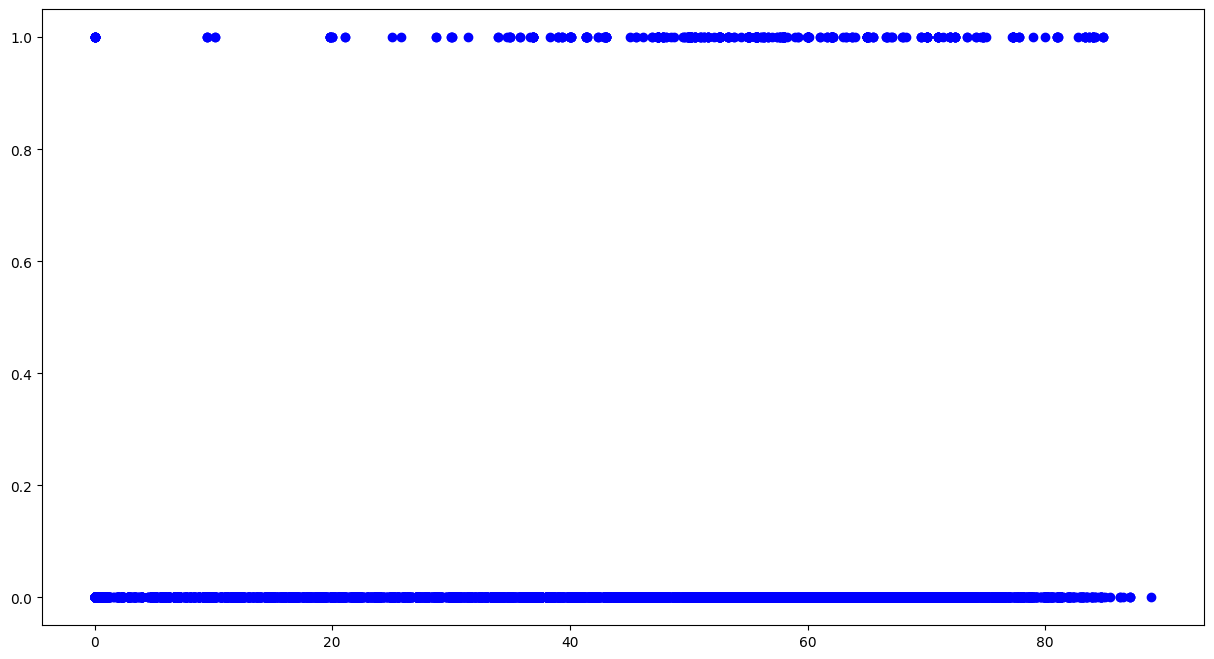

In [29]:
plt.figure(figsize=(15,8))
plt.plot(data['Offer %'],data['title'].str.upper().str.contains('COMBO').astype(int),'bo')

From this plot, it seems like product listings with the word 'Combo' are more likely to give high offers, so i added a column combo telling whether the title contains the word combo

In [30]:
df['combo']=df['title'].str.upper().str.contains('COMBO').astype(int)

Using title column I also divided the data into different shoe types like Shoe/Sandal/Sneaker/Chappal

In [31]:
df['sandal']=df['title'].str.upper().str.contains('SANDAL').astype(int)
df['sneaker']=df['title'].str.upper().str.contains('SNEAKER').astype(int)
df['shoe']=df['title'].str.upper().str.contains('SHOE').astype(int)
df['chappal']=df['title'].str.upper().str.contains('CHAPPAL').astype(int)+df['title'].str.upper().str.contains('SLIDES').astype(int)+df['title'].str.upper().str.contains('FLIP FLOPS').astype(int)

Ultimately I decided that to extract all data from title by looking at most frequent words of title

In [32]:
# 100 most frequent words in title column
from collections import Counter
arr=[]
for i in data['title'].str.split(' '):
  arr+=i
c=Counter(arr)
c_list=c.most_common(100)
c_list

[('For', 10241),
 ('Sandal', 4194),
 ('Shoes', 4163),
 ('Women', 3976),
 ('Running', 2024),
 ('Sneakers', 1806),
 ('Men', 1580),
 ('Black', 1499),
 ('Boots', 1471),
 ('Casual', 1454),
 ('Men\xa0\xa0(Black)', 1454),
 ('Bellies', 1093),
 ('for', 1080),
 ('Jutis', 1073),
 ('Flats', 1054),
 ('Heels', 1008),
 ('Women\xa0\xa0(Black)', 967),
 ('Flip', 894),
 ('Wedges', 875),
 ('Flops', 843),
 ('Stylish', 830),
 ('Walking', 775),
 ('Slip', 711),
 ('Slippers', 679),
 ('On', 663),
 ('Sports', 653),
 ('&', 639),
 ('Slides', 618),
 ('Casuals', 614),
 ('shoes', 593),
 ('Girls', 592),
 ('Women\xa0\xa0(Pink)', 578),
 ('Men\xa0\xa0(Brown)', 529),
 ('|', 505),
 ('Leather', 469),
 ('of', 458),
 ('Mojaris', 458),
 ('Pink', 455),
 ("Men's", 445),
 ('Women\xa0\xa0(Multicolor)', 442),
 ('Lace', 435),
 ('Brown', 435),
 ('Women\xa0\xa0(White)', 432),
 ('and', 430),
 ('Combo', 403),
 ('Grey', 378),
 ('Blue', 371),
 ('Pack', 361),
 ('Women\xa0\xa0(Grey)', 360),
 ('Men\xa0\xa0(Blue)', 356),
 ('High', 351),
 ('La

I then created a list called sp_cols of 100 most frequent words and dropped words like:

- Un-important words like for, of, on....
- Repeated things like men/women, combo, sandals....
- Non descriptive words like Latest/Stylish/Perfect that dont describe the product

In [33]:
# # sp_cols = ['Running', 'Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Walking', 'Slip', 'Sports', 'Casuals', 'Grey', 'Blue', 'Beige', 'Red', 'Brown']
ver_1 = ['Running','Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Stylish', 'Walking', 'Slip', 'Sports', 'Girls', 'Leather', 'Mojaris', 'Pink', 'Lace', 'Brown', 'Combo', 'Grey', 'Blue', 'Pack', 'High', 'Latest', 'Loafers', 'Beige', 'Comfortable', 'White', 'Red', 'Ethnic', 'Multicolor', 'Wear', 'Formal', 'Tan', 'Synthetic', 'Gold', 'Canvas', 'Party', 'Perfect', 'Training', 'IDP', 'Gym', 'Partywear', 'Jutti', 'Ankle', 'Shoe', 'New', 'Fashionable', 'Navy', 'Design', 'Lightweight', 'Derby', ]
ver_colour = ['Black', 'Pink', 'Brown', 'Grey', 'Blue', 'Beige', 'White', 'Red', 'Multicolor','Tan', 'Gold', 'Navy']
ver_2 = ['Running','Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Stylish', 'Walking', 'Slip', 'Sports', 'Girls', 'Leather', 'Mojaris', 'Pink', 'Lace', 'Brown', 'Grey', 'Blue', 'Pack', 'Loafers', 'Beige', 'White', 'Red', 'Ethnic', 'Multicolor', 'Formal', 'Tan', 'Synthetic', 'Gold', 'Canvas', 'Party', 'Training', 'IDP', 'Gym', 'Jutti', 'Ankle', 'New', 'Navy', 'Lightweight', 'Derby']


sp_cols = ver_2

for cl in sp_cols:
    df[cl] = df['title'].str.upper().str.contains(cl.upper()).astype(int)

In [35]:
# Just to check that all strings had correct spelling in list
for cl_ck in sp_cols:
  if df[cl_ck].sum()==0:
    print(df[cl_ck])

In [36]:
df.drop('title',axis='columns',inplace=True)

In [37]:
# Reorganazing columns

df = df[(['Rating', 'norating1',
       'noreviews1', 'star_5f', 'star_4f', 'star_3f', 'star_2f', 'star_1f',
       'actprice1', 'price1', 'fulfilled1', 'combo', 'sandal', 'sneaker', 'shoe', 'chappal', 'logprice', 'maincateg', 'platform']) + sp_cols]

df.head()

,Rating,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,actprice1,price1,...,Party,Training,IDP,Gym,Jutti,Ankle,New,Navy,Lightweight,Derby
0,3.9,38.0,7.0,17.0,9.0,6.0,3,3,999,698,...,0,0,0,0,0,0,0,0,0,0
1,3.8,531.0,69.0,264.0,92.0,73.0,29,73,1999,999,...,0,0,0,0,0,0,0,0,0,0
2,4.4,17.0,4.0,11.0,3.0,2.0,1,0,4999,2749,...,0,0,0,0,0,0,0,0,0,0
3,4.2,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,724,518,...,0,0,0,0,0,0,0,0,0,0
4,3.9,77.0,3.0,35.0,21.0,7.0,7,7,2299,1379,...,0,0,0,0,0,0,0,0,0,0


#Model

##Pipeline

In [38]:
col_enc=make_column_transformer((OneHotEncoder(),['maincateg','platform']),remainder='passthrough')

In [39]:
print(df.shape)
df.head()

(15730, 62)


,Rating,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,actprice1,price1,...,Party,Training,IDP,Gym,Jutti,Ankle,New,Navy,Lightweight,Derby
0,3.9,38.0,7.0,17.0,9.0,6.0,3,3,999,698,...,0,0,0,0,0,0,0,0,0,0
1,3.8,531.0,69.0,264.0,92.0,73.0,29,73,1999,999,...,0,0,0,0,0,0,0,0,0,0
2,4.4,17.0,4.0,11.0,3.0,2.0,1,0,4999,2749,...,0,0,0,0,0,0,0,0,0,0
3,4.2,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,724,518,...,0,0,0,0,0,0,0,0,0,0
4,3.9,77.0,3.0,35.0,21.0,7.0,7,7,2299,1379,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X=df.drop('price1',axis='columns')
y=df['price1']

##Random Forest

In [41]:
# Model after GridSearchCV hyperparametertuning
rfr=RandomForestRegressor(n_estimators=225, max_features=7, bootstrap=False, random_state=2)
pp_rfr=make_pipeline(col_enc,rfr)
rfr_scores=-1*cross_val_score(pp_rfr,X,y,cv=5,scoring='neg_root_mean_squared_error')
rfr_scores.mean()

173.2065514641937

In [42]:
rfr_scores

array([174.01640822, 187.94503697, 173.60418209, 168.88720774,
       161.57992231])

In [43]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=2)
pp_rfr.fit(x_train,y_train)
preds=pp_rfr.predict(x_test)

In [44]:
from sklearn.metrics import r2_score
print(r2_score(y_test,preds))

0.9357426788474689


#Test Data

In [46]:
dft=pd.read_csv('/content/test.csv')
dft_id=dft['id']
print(dft.shape)
dft.head()

(5244, 14)


,id,title,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,2242,Casuals For Men (Blue),3.8,Men,Flipkart,999,27928,3543,14238.0,4295,3457,1962,3976.0,1
1,20532,Women Black Flats Sandal,3.9,Women,Flipkart,499,3015,404,1458.0,657,397,182,321.0,1
2,10648,Women Gold Wedges Sandal,3.9,Women,Flipkart,999,449,52,229.0,70,71,33,46.0,1
3,20677,Men's Height Increasing High Heel Formal Party...,3.9,Men,Flipkart,2999,290,40,141.0,51,49,17,32.0,1
4,12593,Loafers For Men (Tan),3.9,Men,Flipkart,999,2423,326,1265.0,414,293,143,308.0,0


In [47]:
dft.isnull().sum()

id              0
title           0
Rating        203
maincateg      67
platform        0
actprice1       0
norating1       0
noreviews1      0
star_5f        68
star_4f         0
star_3f         0
star_2f         0
star_1f       186
fulfilled1      0
dtype: int64

Handled maincateg and star_f null values same way as done with training data

In [48]:
dft.loc[dft['title'].str.upper().str.contains('WOMEN')&dft['maincateg'].isnull(),['maincateg']]='Women'
dft.loc[dft['title'].str.upper().str.contains('MEN')&dft['maincateg'].isnull(),['maincateg']]='Men'
dft.loc[dft['maincateg'].isnull(),['maincateg']]='Unisex'
dft.isnull().sum()

id              0
title           0
Rating        203
maincateg       0
platform        0
actprice1       0
norating1       0
noreviews1      0
star_5f        68
star_4f         0
star_3f         0
star_2f         0
star_1f       186
fulfilled1      0
dtype: int64

In [49]:
lrm5t=XGBRegressor()
x_lrm5t=np.array(dft.loc[dft['star_5f'].notna(),['Rating','star_4f','star_3f','star_2f']])
y_lrm5t=np.array(dft[dft['star_5f'].notna()]['star_5f'])
lrm5t.fit(x_lrm5t,y_lrm5t)
dft.loc[dft['star_5f'].isnull(),'star_5f']=lrm5t.predict(np.array(dft.loc[dft['star_5f'].isnull(),['Rating','star_4f','star_3f','star_2f']]))

In [50]:
lrm1t=XGBRegressor()
x_lrm1t=np.array(dft.loc[dft['star_1f'].notna(),['Rating','star_4f','star_3f','star_2f']])
y_lrm1t=np.array(dft[dft['star_1f'].notna()]['star_1f'])
lrm1t.fit(x_lrm1t,y_lrm1t)
dft.loc[dft['star_1f'].isnull(),'star_1f']=lrm1t.predict(np.array(dft.loc[dft['star_1f'].isnull(),['Rating','star_4f','star_3f','star_2f']]))

In [51]:
dft.isnull().sum()

id              0
title           0
Rating        203
maincateg       0
platform        0
actprice1       0
norating1       0
noreviews1      0
star_5f         0
star_4f         0
star_3f         0
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

In [52]:
dft.loc[dft['Rating'].isnull(),'Rating']=((dft.loc[dft['star_5f'].isnull(),'star_5f'])*5+(dft.loc[dft['star_4f'].isnull(),'star_4f'])*4+(dft.loc[dft['star_3f'].isnull(),'star_3f'])*3+(dft.loc[dft['star_2f'].isnull(),'star_2f'])*2+(dft.loc[dft['star_1f'].isnull(),'star_1f'])*1)/((dft.loc[dft['star_5f'].isnull(),'star_5f'])+(dft.loc[dft['star_4f'].isnull(),'star_4f'])+(dft.loc[dft['star_3f'].isnull(),'star_3f'])+(dft.loc[dft['star_2f'].isnull(),'star_2f'])+(dft.loc[dft['star_1f'].isnull(),'star_1f']))

Training data didnt have Rating null values, handled this by taking weighted avg of star_f columns

In [53]:
dft[dft['Rating'].isnull()]

,id,title,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
35,17580,Women Beige Heels Sandal,NaN,Women,Flipkart,999,473,68,198.662460,119,45,16,34.730263,1
84,11588,Royal Jutis For men Mojaris For Men (Black),NaN,Men,Flipkart,899,41,7,22.000000,9,3,1,6.000000,0
88,15449,Flip Flops,NaN,Unisex,Flipkart,499,3073,401,1248.000000,517,510,274,586.715759,1
90,12342,"Men Black, Blue Sports Sandal",NaN,Men,Flipkart,2499,52,5,35.540771,13,6,4,9.092834,1
91,9065,Sneakers For Men (Black),NaN,Men,Flipkart,999,2465,274,1408.000000,407,258,137,260.367218,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5164,9552,Mojaris Jutis For Men (Black),NaN,Men,Flipkart,499,11,2,8.000000,0,0,1,1.644266,0
5177,16621,Women Black Flats Sandal,NaN,Women,Flipkart,599,1057,94,655.641785,229,172,79,130.764343,1
5179,9466,Flip Flops,NaN,Men,Flipkart,499,5227,686,2539.000000,1019,687,344,583.947021,0
5188,3575,Ethnic Mule For Women (Pink),NaN,Women,Flipkart,699,53,8,30.000000,9,7,2,7.320309,0


In [54]:
dft.loc[dft['Rating'].isnull(),'Rating']=0
dft.isnull().sum()

id            0
title         0
Rating        0
maincateg     0
platform      0
actprice1     0
norating1     0
noreviews1    0
star_5f       0
star_4f       0
star_3f       0
star_2f       0
star_1f       0
fulfilled1    0
dtype: int64

Completing Feature Transformations on testing data

In [55]:
dft['combo']=dft['title'].str.upper().str.contains('COMBO').astype(int)
dft['sandal']=dft['title'].str.upper().str.contains('SANDAL').astype(int)
dft['shoe']=dft['title'].str.upper().str.contains('SHOE').astype(int)
dft['sneaker']=dft['title'].str.upper().str.contains('SNEAKER').astype(int)
dft['chappal']=(dft['title'].str.upper().str.contains('CHAPPAL')|dft['title'].str.upper().str.contains('FLIP FLOPS')|dft['title'].str.upper().str.contains('SLIDES')).astype(int)

In [56]:
dft['logprice']=np.log(dft['actprice1'])
dft.head()

,id,title,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,combo,sandal,shoe,sneaker,chappal,logprice
0,2242,Casuals For Men (Blue),3.8,Men,Flipkart,999,27928,3543,14238.0,4295,3457,1962,3976.0,1,0,0,0,0,0,6.906755
1,20532,Women Black Flats Sandal,3.9,Women,Flipkart,499,3015,404,1458.0,657,397,182,321.0,1,0,1,0,0,0,6.212606
2,10648,Women Gold Wedges Sandal,3.9,Women,Flipkart,999,449,52,229.0,70,71,33,46.0,1,0,1,0,0,0,6.906755
3,20677,Men's Height Increasing High Heel Formal Party...,3.9,Men,Flipkart,2999,290,40,141.0,51,49,17,32.0,1,0,0,0,0,0,8.006034
4,12593,Loafers For Men (Tan),3.9,Men,Flipkart,999,2423,326,1265.0,414,293,143,308.0,0,0,0,0,0,0,6.906755


In [57]:
for cl in sp_cols:
  dft[cl]=dft['title'].str.upper().str.contains(cl.upper()).astype(int)

In [58]:
dft.drop(['id','title'],axis='columns',inplace=True)
dft.shape

(5244, 61)

In [59]:
pp_rfr.fit(X,y)
preds=pp_rfr.predict(dft)
df_sub=pd.DataFrame({'id':dft_id.values,'price1':preds})

In [60]:
df_sub.to_csv('Submission.csv',index=False)